In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
stock_df = pd.read_csv('C:/Users/Dell/Downloads/stockpredrictionDataset/TCS.BO.csv')

In [3]:
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-08-26,915.000000,938.250000,907.500000,919.349976,731.606750,362810.0
1,2013-08-27,915.049988,935.974976,913.500000,918.525024,730.950256,369042.0
2,2013-08-28,915.000000,971.000000,914.900024,952.299988,757.828186,430378.0
3,2013-08-29,952.674988,984.500000,938.500000,973.075012,774.360474,541306.0
4,2013-08-30,970.049988,1020.000000,965.250000,1011.575012,804.998413,598504.0


In [4]:
stock_df = stock_df.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
stock_df.head()

,date,open,high,low,close,adj_close,volume
0,2013-08-26,915.000000,938.250000,907.500000,919.349976,731.606750,362810.0
1,2013-08-27,915.049988,935.974976,913.500000,918.525024,730.950256,369042.0
2,2013-08-28,915.000000,971.000000,914.900024,952.299988,757.828186,430378.0
3,2013-08-29,952.674988,984.500000,938.500000,973.075012,774.360474,541306.0
4,2013-08-30,970.049988,1020.000000,965.250000,1011.575012,804.998413,598504.0


In [5]:
stock_df.shape

(2469, 7)

In [6]:
stock_df.isnull().sum()

date          0
open         23
high         23
low          23
close        23
adj_close    23
volume       23
dtype: int64

In [7]:
stock_df.dropna(inplace=True)
print("Null values:", stock_df.isnull().values.sum())
print("NA values:", stock_df.isna().values.any())

Null values: 0
NA values: False


In [8]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2446 entries, 0 to 2468
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       2446 non-null   object 
 1   open       2446 non-null   float64
 2   high       2446 non-null   float64
 3   low        2446 non-null   float64
 4   close      2446 non-null   float64
 5   adj_close  2446 non-null   float64
 6   volume     2446 non-null   float64
dtypes: float64(6), object(1)
memory usage: 152.9+ KB


In [9]:
stock_df['date'] = pd.to_datetime(stock_df['date'], utc=True)

In [10]:
print("Starting date: ",stock_df.iloc[0][0])
print("Ending date: ", stock_df.iloc[-1][0])
print("Duration: ", stock_df.iloc[-1][0]-stock_df.iloc[0][0])

Starting date:  2013-08-26 00:00:00+00:00
Ending date:  2023-08-25 00:00:00+00:00
Duration:  3651 days 00:00:00


In [11]:
OHLC_avg = stock_df[['open','high', 'low', 'close']].mean(axis=1)
HLC_avg = stock_df[['high', 'low', 'close']].mean(axis = 1)

In [14]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price','OHLC Average'])
fig = px.line(stock_df, x=stock_df.date, y=[stock_df['open'], stock_df['close'], 
                                          stock_df['high'], stock_df['low'],OHLC_avg],
             labels={'date': 'Date','value':'Stock value'})

fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)

fig.update_yaxes(showgrid=False)

fig.show()

In [32]:
stock_df_OHLC=pd.DataFrame({'date':stock_df['date'],'close':OHLC_avg})

In [33]:
print("Shape of close dataframe:", stock_df_HLC.shape)

Shape of close dataframe: (2446, 2)


In [34]:
stock_df_OHLC_Orignal=stock_df_OHLC.copy()
print("Total data for prediction: ",stock_df_OHLC.shape[0])

Total data for prediction:  2446


In [35]:
fig = px.line(stock_df_OHLC, x=stock_df_OHLC.date, y=stock_df_OHLC.close,labels={'date':'Date','close':'Close Stock'})

fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')

fig.update_layout(title_text='Considered period to predict Stock close price', plot_bgcolor='white', font_size=15, font_color='black')

fig.update_xaxes(showgrid=False)

fig.update_yaxes(showgrid=False)

fig.show()

In [36]:
training_size=int(len(stock_df_OHLC)*0.80)

test_size=len(stock_df_OHLC)-training_size

train_data,test_data = stock_df_OHLC[0:training_size], stock_df_OHLC[training_size:len(stock_df_OHLC)]

print("train_data: ", train_data.shape)  # (201, 2)

print("test_data: ", test_data.shape)

train_data:  (1956, 2)
test_data:  (490, 2)


In [37]:
del train_data['date']

del test_data['date']

In [38]:
scaler=MinMaxScaler(feature_range=(0,1))

train_data=scaler.fit_transform(np.array(train_data).reshape(-1,1))

test_data = scaler.transform(np.array(test_data).reshape(-1,1))

print(train_data.shape)

(1956, 1)


In [39]:
def create_sliding_window(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [40]:
time_step = 50

X_train, y_train = create_sliding_window(train_data, time_step)

X_test, y_test = create_sliding_window(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1905, 50)
y_train:  (1905,)
X_test:  (439, 50)
y_test (439,)


In [41]:
X_train =X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1905, 50, 1)
X_test:  (439, 50, 1)


In [42]:
model=Sequential()

model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))

model.add(GRU(32,return_sequences=True))

model.add(GRU(32))

model.add(Dropout(0.20))

model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 50, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 16065 (62.75 KB)
Trainable params: 16065 (62.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
history = model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
60/60 [==============================] - 15s 110ms/step - loss: 0.0126 - val_loss: 0.0036
Epoch 2/100
60/60 [==============================] - 5s 83ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 3/100
60/60 [==============================] - 5s 84ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 4/100
60/60 [==============================] - 6s 100ms/step - loss: 0.0016 - val_loss: 6.7120e-04
Epoch 5/100
60/60 [==============================] - 7s 112ms/step - loss: 0.0017 - val_loss: 5.8492e-04
Epoch 6/100
60/60 [==============================] - 6s 95ms/step - loss: 0.0014 - val_loss: 7.1990e-04
Epoch 7/100
60/60 [==============================] - 6s 103ms/step - loss: 0.0015 - val_loss: 5.1280e-04
Epoch 8/100
60/60 [==============================] - 6s 98ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 9/100
60/60 [==============================] - 5s 91ms/step - loss: 0.0015 - val_loss: 7.7834e-04
Epoch 10/100
60/60 [==============================] - 5s 84ms/step - loss: 

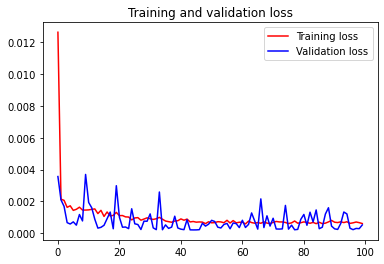

<Figure size 432x288 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')

plt.legend(loc=0)

plt.figure()


plt.show()

In [46]:
train_predict=model.predict(X_train)

test_predict=model.predict(X_test)

train_predict.shape, test_predict.shape

14/14 [==============================] - 0s 23ms/step


((1905, 1), (439, 1))

In [47]:
train_predict = scaler.inverse_transform(train_predict)

test_predict = scaler.inverse_transform(test_predict)

original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 

original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [48]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain, train_predict)))

print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))

print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))

print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))

print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))

print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  25.666878051359113
Train data MSE:  658.7886289033402
Train data MAE:  17.930346133630664
Test data RMSE:  56.52031586846196
Test data MSE:  3194.546105870713
Test data MAE:  47.35939530321041


In [49]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))

print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9986593405125551
Test data explained variance regression score: 0.9692687031658659


In [50]:
del stock_df_OHLC['date']

look_back=time_step

train_predict_look_ahead = np.empty_like(stock_df_OHLC)

train_predict_look_ahead[:, :] = np.nan

train_predict_look_ahead[look_back:len(train_predict)+look_back, :] = train_predict

print("Train predicted data: ", train_predict_look_ahead.shape)
# shift test predictions for plotting
test_predict_look_ahead = np.empty_like(stock_df_OHLC)

test_predict_look_ahead[:, :] = np.nan

test_predict_look_ahead[len(train_predict)+(look_back*2)+1:len(stock_df_OHLC)-1, :] = test_predict

print("Test predicted data: ", test_predict_look_ahead.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': stock_df_OHLC_Orignal['date'],
                       'original_close': stock_df_OHLC_Orignal['close'],
                      'train_predicted_close': train_predict_look_ahead.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': test_predict_look_ahead.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})

fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2446, 1)
Test predicted data:  (2446, 1)


In [105]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1) # time_step is 15
print("x_input.shape ", x_input.shape)
print("x_input", x_input)
temp_input=list(x_input)
print(temp_input)

x_input.shape  (1, 50)
x_input [[0.97189197 0.97351789 0.96785258 0.97433085 0.97289291 0.96877734
  0.95049589 0.94988113 0.94802146 0.93818974 0.93925678 0.94763533
  0.94450035 0.93822024 0.92059934 0.92401378 0.93436377 0.94535903
  0.94745749 0.93788488 0.92418144 0.92567527 0.93103063 0.95116153
  0.97592627 0.96634355 1.02313377 1.0518007  1.04141516 1.03182226
  1.00666118 1.00324166 1.00589395 0.99444651 1.01056846 1.01767679
  1.03412394 1.03837168 1.03112616 1.0256895  1.02541004 1.02225477
  1.02956122 1.02573016 1.00210861 1.00243888 1.00409528 1.00404953
  1.00660531 0.99694126]]
[array([0.97189197, 0.97351789, 0.96785258, 0.97433085, 0.97289291,
       0.96877734, 0.95049589, 0.94988113, 0.94802146, 0.93818974,
       0.93925678, 0.94763533, 0.94450035, 0.93822024, 0.92059934,
       0.92401378, 0.93436377, 0.94535903, 0.94745749, 0.93788488,
       0.92418144, 0.92567527, 0.93103063, 0.95116153, 0.97592627,
       0.96634355, 1.02313377, 1.0518007 , 1.04141516, 1.031822

In [106]:
outx_input = x_input.reshape((1, 50,1)) 
output=model.predict(outx_input, verbose=0)

In [107]:
print('expected value for next day',scaler.inverse_transform(output)[0])

expected value for next day [3318.4387]


In [108]:
temp_input=temp_input[0].tolist()
len(temp_input)

50

In [109]:
from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        y_pred = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,y_pred))
        temp_input.extend(y_pred[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(y_pred.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1)) # Reshape x_input to a 3D Tensor [samples, time steps, features] before feeding into the model 
        y_pred = model.predict(x_input, verbose=0)
        temp_input.extend(y_pred[0].tolist())
        
        lst_output.extend(y_pred.tolist())
        i=i+1

In [110]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
[51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80]


In [111]:
temp_matrix = np.empty((len(last_days)+pred_days+1, 1))

temp_matrix[:] = np.nan

In [112]:
temp_matrix.shape

(81, 1)

In [113]:
temp_matrix = temp_matrix.reshape(1,-1).tolist()[0]


In [114]:
last_original_days_value = temp_matrix

next_predicted_days_value = temp_matrix

last_original_days_value[0:time_step+1] = stock_df_OHLC_Orignal[len(stock_df_OHLC_Orignal)-time_step:]['close'].tolist()

next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]


In [115]:
last_original_days_value[0:time_step+1]


[3311.0250244999997,
 3315.0250244999997,
 3301.0875244999997,
 3317.0250244999997,
 3313.4874877500006,
 3303.3625489999995,
 3258.3874510000005,
 3256.87506125,
 3252.2999877500006,
 3228.11248775,
 3230.737549,
 3251.3500367499996,
 3243.63751225,
 3228.1875,
 3184.83746325,
 3193.2374877499997,
 3218.70001225,
 3245.75,
 3250.91253675,
 3227.36248775,
 3193.64996325,
 3197.3250122500003,
 3210.5,
 3260.0250244999997,
 3320.95001225,
 3297.37506125,
 3437.0875244999997,
 3507.61248775,
 3482.0625,
 3458.4625244999997,
 3396.5625,
 3388.1499632500004,
 3394.6749877499997,
 3366.5125735,
 3406.17498775,
 3423.6625367499996,
 3464.125,
 3474.5750735,
 3456.75,
 3443.375,
 3442.6875,
 3434.9250489999995,
 3452.9000244999997,
 3443.47503675,
 3385.3624877499997,
 3386.17498775,
 3390.25,
 3390.137451,
 3396.425049,
 3372.6500244999997,
 nan]

In [116]:
next_predicted_days_value[time_step+1:]

[3318.438731283573,
 3257.217461736194,
 3199.589956258302,
 3146.0899712238543,
 3095.6775615218335,
 3047.8981544161775,
 3002.5417666300987,
 2959.379645431902,
 2918.1647085440823,
 2878.6709893259067,
 2840.7037546827014,
 2804.0956925203213,
 2768.702805926892,
 2734.3995741727135,
 2701.0777796193297,
 2668.643574992199,
 2637.0154304715625,
 2606.1223740560486,
 2575.9023785626396,
 2546.3010418993745,
 2517.270413974417,
 2488.7687034233227,
 2460.759104518107,
 2433.20921062178,
 2406.09042764288,
 2379.37768076274,
 2353.0485346172895,
 2327.083633206155,
 2301.4658200744584,
 2276.180284949187]

In [117]:
new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

new_pred_plot.tail()

,last_original_days_value,next_predicted_days_value
76,2379.377681,2379.377681
77,2353.048535,2353.048535
78,2327.083633,2327.083633
79,2301.465820,2301.465820
80,2276.180285,2276.180285


In [118]:
names = cycle(['Last 15 days close price','Predicted next 20 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'], new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})

fig.update_layout(title_text='Compare last 50 days vs next 20 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(visible=True, name = next(names)))

fig.update_xaxes(showgrid=False)

fig.update_yaxes(showgrid=False)

fig.show()

In [119]:

stock_df_c = scaler.transform(np.array(stock_df_OHLC).reshape(-1,1))
lstmdf=stock_df_c.tolist()

lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())

lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})

fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()